## Dataset Au-Au: ponta de ouro e substrato de ouro
### Teste 20.1 - 2x2, `grid_eight`, 100 séries temporais aleatórias.
Esse notebook tem um diferencial em relação aos anteriores: nele, foi feito um teste sequencial ou recursivo, ou seja, foi uma clusterização inicial para separar os motifs que pegam a área de interesse de estudo da curva, seguido de uma outra clusterização para identificar diferentes padrões nessas curvas. Para isso, aplicamos uma rede com dimensão 2x2 em nossos dados, e utilizamos o melhor cluster para aplicar uma rede 3x3 para agrupamentos dos motifs deste.
### Importando bibliotecas e dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import random
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [2]:
D3011_data = np.load('dataset_TipAu_Au.npz')

In [3]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_Au.npz' with keys: smoothedMeasuredHeight_m, vDeflection_N, height_m, measuredHeight_m, seriesTime_s...)

In [4]:
list(D3011_data.keys())

['smoothedMeasuredHeight_m',
 'vDeflection_N',
 'height_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [5]:
force_data = D3011_data['vDeflection_N']

In [6]:
force_data.shape

(1024, 800)

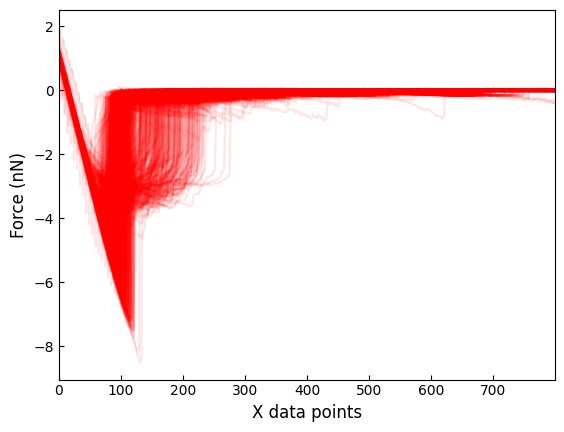

In [7]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Para essa clusterização, foram selecionados as **100 curvas aleatórias** do *dataset*, utilizando uma semente para possibilitar a reprodutibilidade.

In [8]:
random.seed(1025)
random.shuffle(force_data)

In [9]:
train_set = force_data[:100]
test_set = force_data[100:]

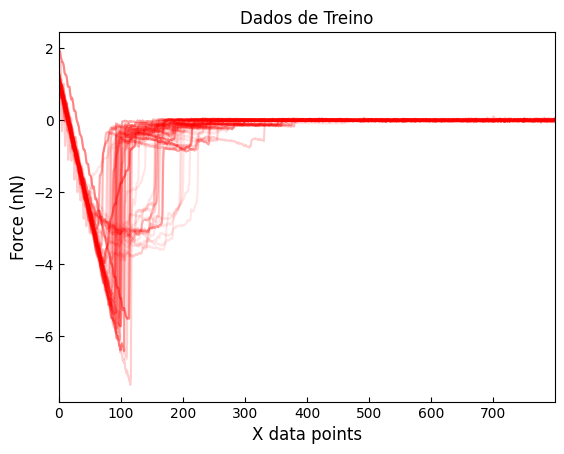

In [10]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [11]:
len(train_set[0])

800

### Concatenando os dados e descobrindo motifs
Todas as curvas foram concatenadas em uma única série temporal, como indicado no artigo de base, do desenvolvimento do método DTW-SOM.

In [14]:
size = len(train_set[0])
sample_size = len(train_set)
print(size, sample_size)

800 100


In [15]:
joined_data = train_set[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set[i]))
len(joined_data)

80000

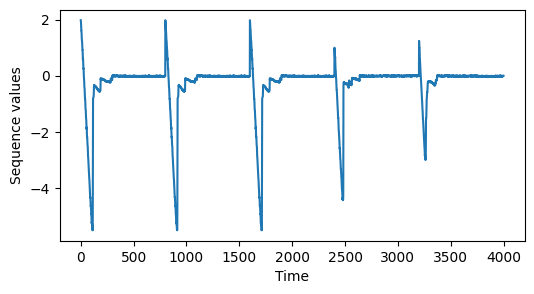

In [16]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [17]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 48.4 s, sys: 10.7 s, total: 59.1 s
Wall time: 59.1 s


In [18]:
print(mp[1])

[  800.   801.   802. ... 31998. 31999. 32000.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

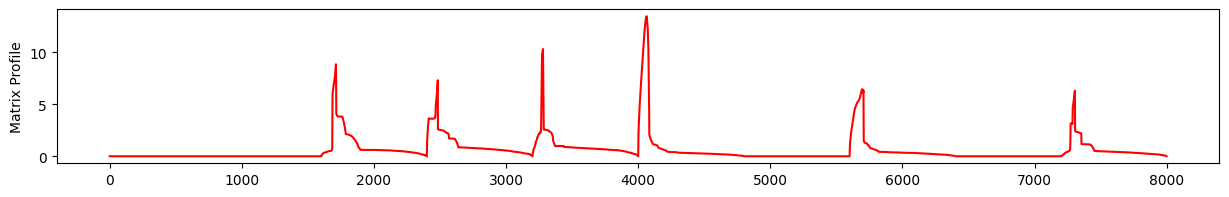

In [19]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [20]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 235 ms, sys: 131 ms, total: 366 ms
Wall time: 330 ms


47

Criando uma lista com os centros de motifs.

In [21]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

80000

In [22]:
len(motif_center_list)

47

### Treinando a rede DTW-SOM

In [23]:
%time
rows = 2
cols = 2
structure = type_conn.grid_eight
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [24]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 6.3036
Epoch 2 achieved an average quantization error of 7.6662
Epoch 3 achieved an average quantization error of 8.0759
Epoch 4 achieved an average quantization error of 8.3793
Epoch 5 achieved an average quantization error of 8.4903
Epoch 6 achieved an average quantization error of 8.487
Epoch 7 achieved an average quantization error of 8.5208
Epoch 8 achieved an average quantization error of 8.5241
Epoch 9 achieved an average quantization error of 8.5171
Epoch 10 achieved an average quantization error of 8.5336
Epoch 11 achieved an average quantization error of 8.561
Epoch 12 achieved an average quantization error of 8.3365
Epoch 13 achieved an average quantization error of 7.677
Epoch 14 achieved an average quantization error of 7.4947
Epoch 15 achieved an average quantization error of 7.3256
Epoch 16 achieved an average quantization error of 7.2228
Epoch 17 achieved an average quantization error of 7.1591
Epoch 18 achieved an avera

50

### Resultados

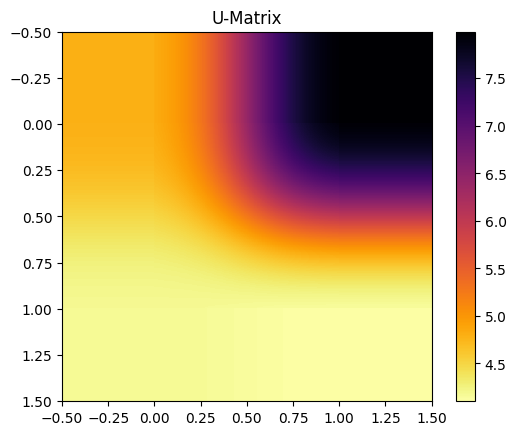

In [25]:
network.show_distance_matrix()

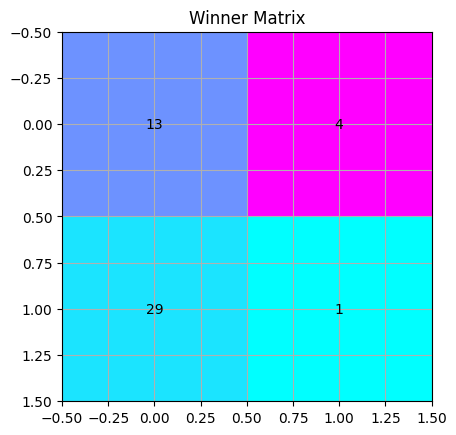

In [26]:
network.show_winner_matrix()

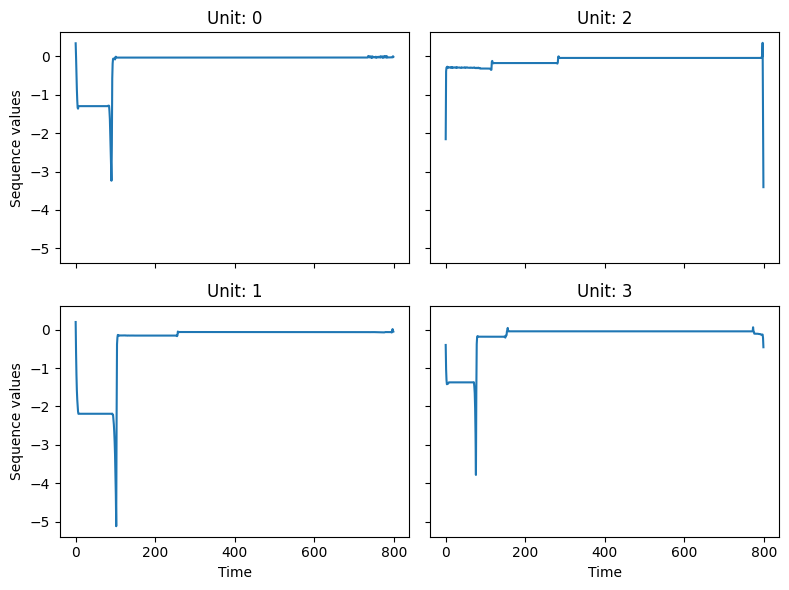

In [27]:
n_neurons = network._size
fig, axs = plt.subplots(2,2,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/2) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 2
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

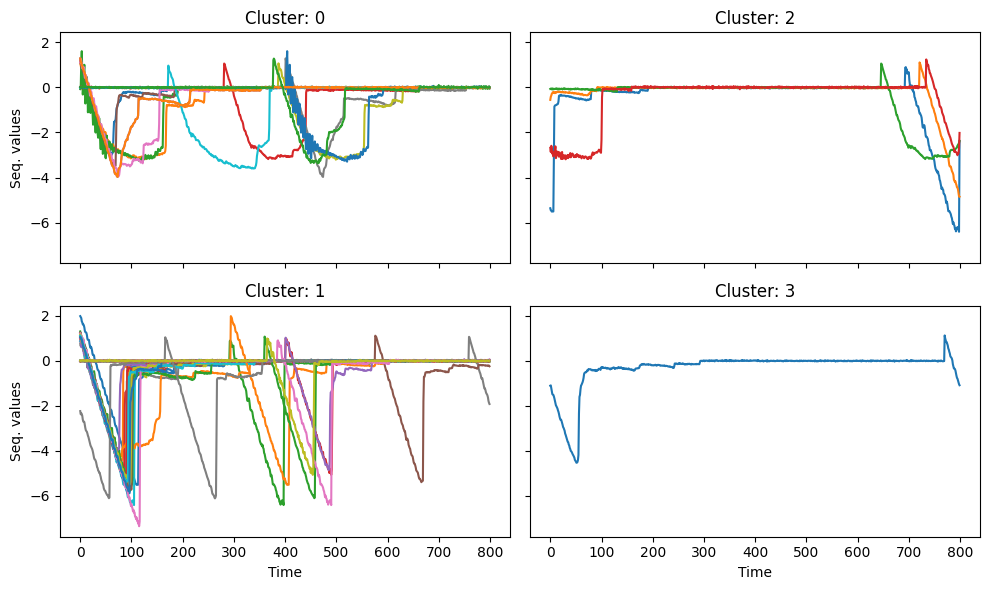

In [28]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

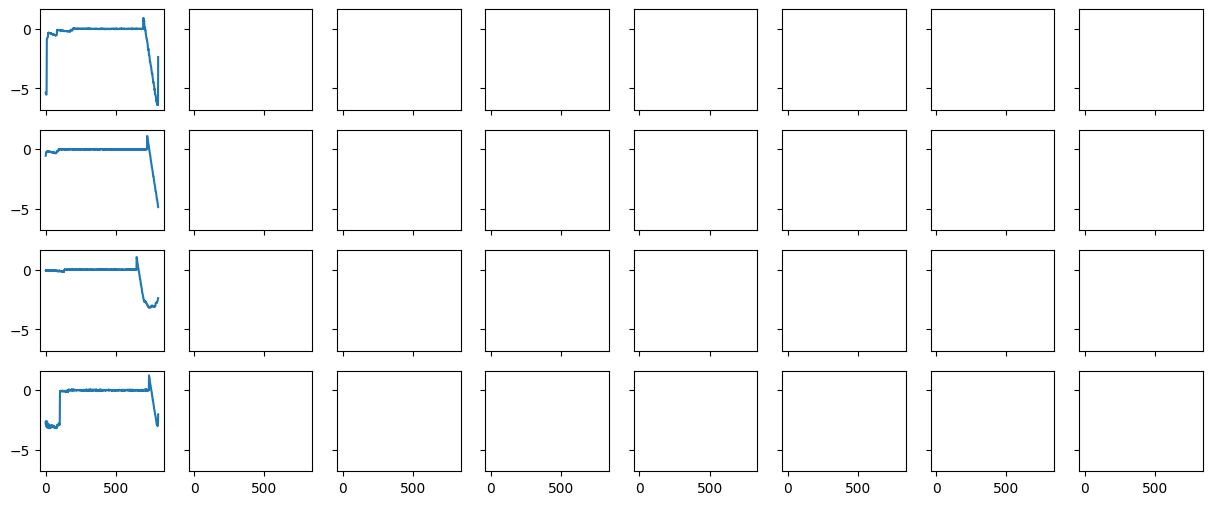

In [29]:
fig, axs = plt.subplots(4, 8,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[2]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/4)
    row = i % 4
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

### Teste 20.2 - 3x3, `grid_eight`, motifs dos clusters 0 e 1 do teste 20.1.

In [32]:
cluster0 = network.capture_objects[0]
cluster1 = network.capture_objects[1]

cluster = []
for c0 in cluster0:
    cluster.append(c0)
for c1 in cluster1:
    cluster.append(c1)

cluster

[2,
 6,
 7,
 10,
 13,
 16,
 28,
 33,
 42,
 43,
 44,
 45,
 46,
 0,
 1,
 4,
 5,
 8,
 9,
 11,
 12,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 36,
 37,
 38,
 39]

In [34]:
new_motifs = [mtfs[i] for i in cluster]

In [35]:
motif_center_list2 = []
for motif in new_motifs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list2.append(motif_center)

In [36]:
len(motif_center_list2)

42

##### Treinando a nova rede neural

In [37]:
%time
rows2 = 3
cols2 = 3
structure = type_conn.grid_eight
network2 = dtwsom.DtwSom(rows2, cols2, structure)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [38]:
%%time
network2.train(motif_center_list2, 50)

Epoch 1 achieved an average quantization error of 2.6932
Epoch 2 achieved an average quantization error of 3.0089
Epoch 3 achieved an average quantization error of 3.1177
Epoch 4 achieved an average quantization error of 3.1152
Epoch 5 achieved an average quantization error of 3.1951
Epoch 6 achieved an average quantization error of 3.3038
Epoch 7 achieved an average quantization error of 3.2548
Epoch 8 achieved an average quantization error of 3.2085
Epoch 9 achieved an average quantization error of 3.1749
Epoch 10 achieved an average quantization error of 3.1463
Epoch 11 achieved an average quantization error of 3.1494
Epoch 12 achieved an average quantization error of 3.1488
Epoch 13 achieved an average quantization error of 3.1513
Epoch 14 achieved an average quantization error of 3.1503
Epoch 15 achieved an average quantization error of 3.1449
Epoch 16 achieved an average quantization error of 3.1302
Epoch 17 achieved an average quantization error of 3.1137
Epoch 18 achieved an av

50

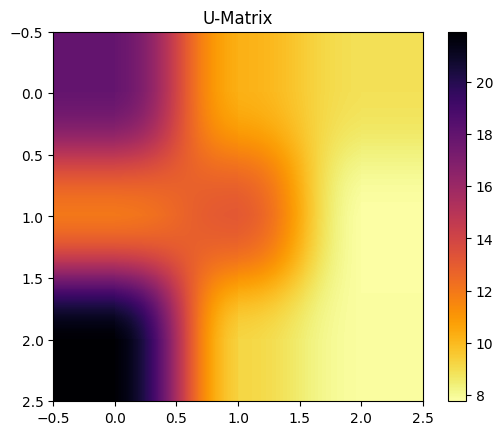

In [39]:
network2.show_distance_matrix()

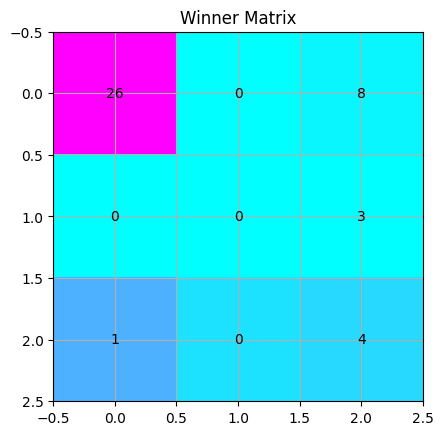

In [40]:
network2.show_winner_matrix()

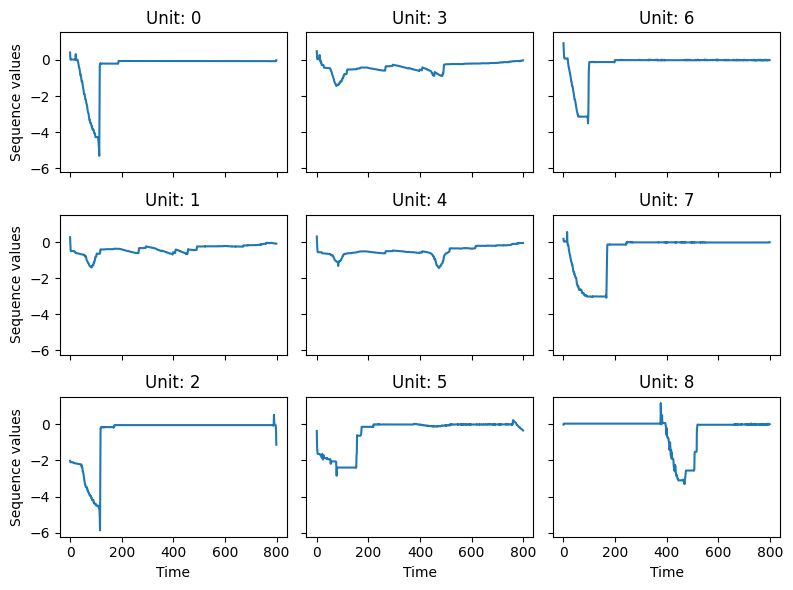

In [41]:
n_neurons = network2._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 3
    neuron_weights = network2._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

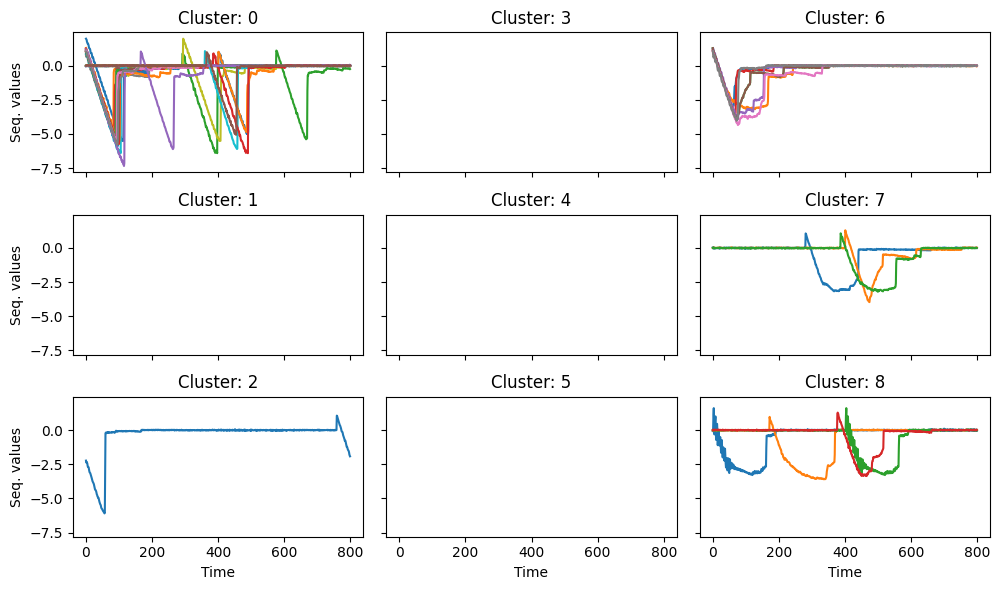

In [42]:
n = rows2
n_neurons = network2._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network2.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list2[member_index])), motif_center_list2[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

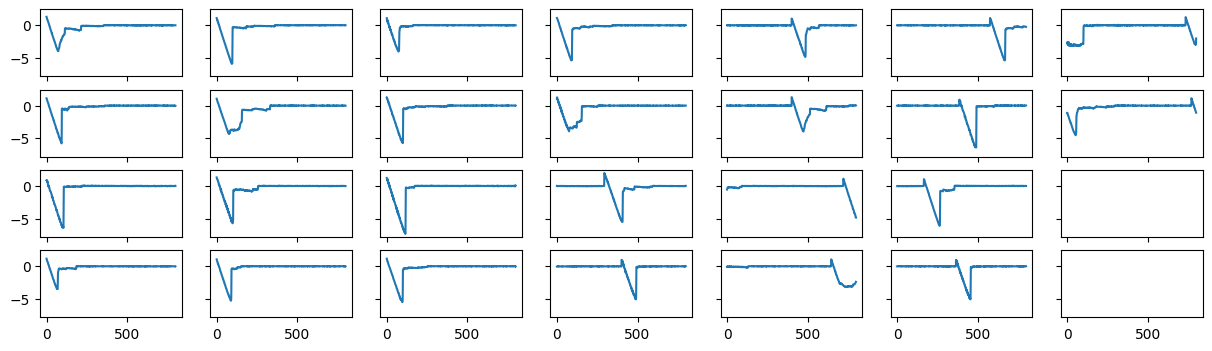

In [45]:
fig, axs = plt.subplots(4, 7,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network2.capture_objects[0]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/4)
    row = i % 4
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

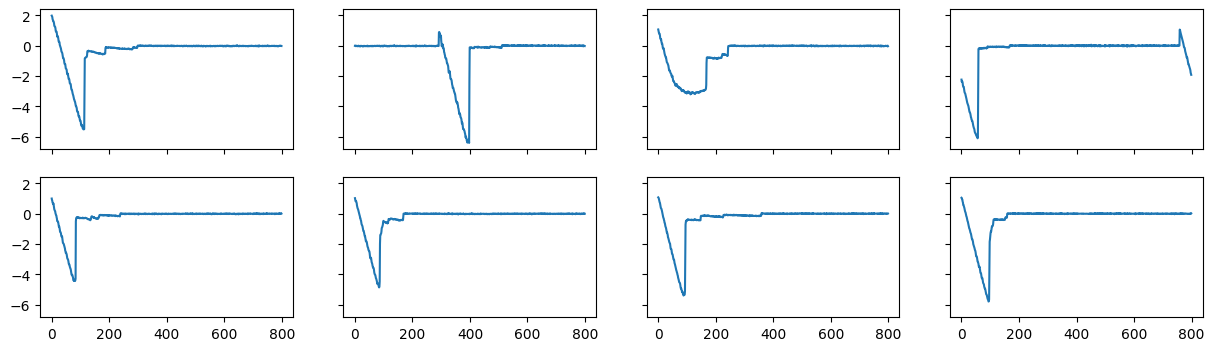

In [47]:
fig, axs = plt.subplots(2, 4,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network2.capture_objects[6]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

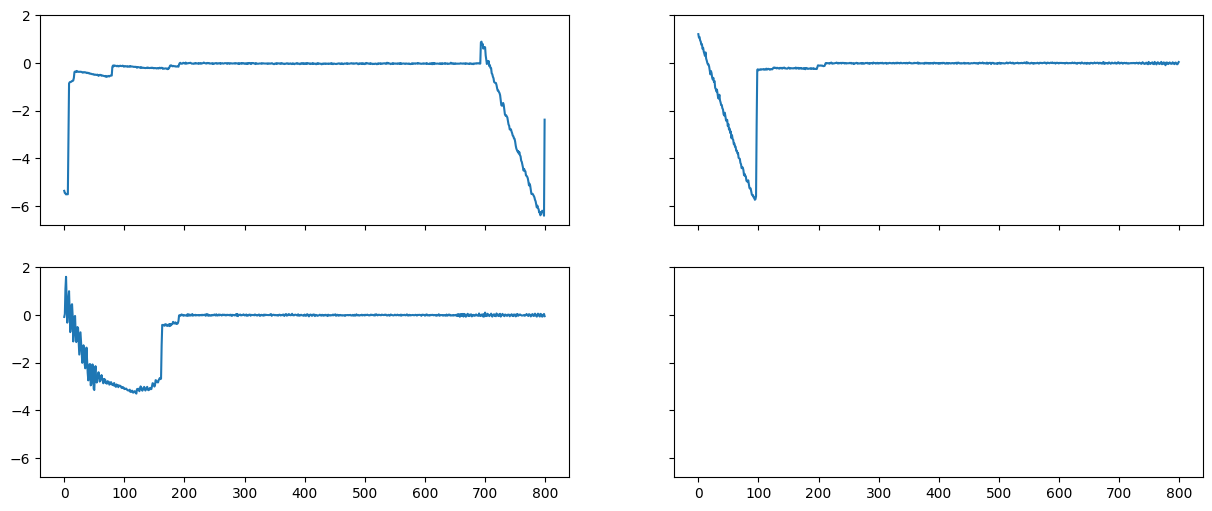

In [48]:
fig, axs = plt.subplots(2, 2,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network2.capture_objects[7]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

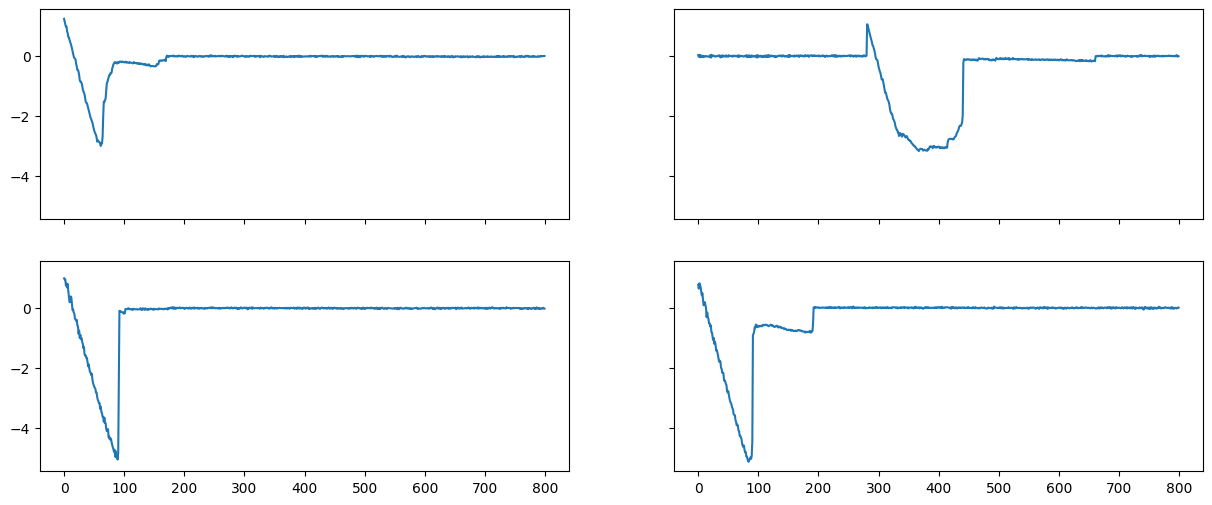

In [49]:
fig, axs = plt.subplots(2, 2,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network2.capture_objects[8]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()